# 모듈 불러오기

In [2]:
from keras import applications, optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import *
from skimage.transform import rotate
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import os

Using TensorFlow backend.


# 경로 설정하기

In [3]:
BASE_PATH = 'D:\\yonsei_tutoring'
TRAIN_DATA_PATH = os.path.join(BASE_PATH, 'classification', 'Open_I_abd_vs_CXRs', 'TRAIN')
VAL_DATA_PATH = os.path.join(BASE_PATH, 'classification', 'Open_I_abd_vs_CXRs', 'VAL')
TEST_DATA_PATH = os.path.join(BASE_PATH, 'classification', 'Open_I_abd_vs_CXRs', 'TEST', 'abd2.png')

# 하이퍼 파라미터

하이퍼 파라미터를 이용해 인공지능 모델을 조정합니다.  
주로 사용하는 하이퍼 파라미터는 다음과 같습니다.

In [4]:
IMG_HEIGHT, IMG_WIDTH = (256, 256)
EPOCHS = 10
BATCH_SIZE = 5
LEARNING_RATE = 1e-2 
DECAY_RATE = 0
INIT_FILTERS = 32
ACTIVATION_FN = 'relu' # relu, elu, sigmoid
DROP_RATE = 0.25

# 데이터 불러오기
AI 모델 학습에 사용할 데이터를 불러오겠습니다.  

In [5]:
train_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(directory=TRAIN_DATA_PATH,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    seed=42)
val_generator = val_datagen.flow_from_directory(directory=VAL_DATA_PATH,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary',
                                                shuffle=False,
                                                seed=42)

Found 65 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


# **AI 모델을 구성하는 레이어 만들기**

AI 모델은 여러 개의 레이어를 쌓아 올려 만듭니다.  
가장 대표적인 레이어 구조인 **CONV-BN-ACT-POOL** 구조를 만들어 보겠습니다.

먼저 데이터가 들어가는 첫 번째 레이어를 만들어 봅시다.

In [16]:
first_layer = Input(shape=(32, 32, 3))

그 다음으로 데이터의 특징을 추출할 Convolution 레이어를 연결하겠습니다.

In [17]:
second_layer = Conv2D(filters=8, kernel_size=(3, 3), activation=None, padding='same')(first_layer)

다음으로 레이어 중간에서 정규화를 도와줄 Batch Normalization 레이어를 추가하겠습니다.

In [18]:
third_layer = BatchNormalization()(second_layer)

Batch Normalization 이후 신호를 변환하여 다음 뉴런으로 전달하는 Activation function 레이어를 추가합니다.

In [19]:
fourth_layer = Activation('relu')(third_layer)

다음으로 이미지 사이즈를 줄여주는 Pooling 레이어를 연결합니다.

In [20]:
fifth_layer = MaxPool2D(strides=(2, 2))(fourth_layer)

그 후 모든 뉴런을 일렬로 늘어세우는 Flatten 레이어를 만듭니다.

In [21]:
sixth_layer = Flatten()(fifth_layer)

일렬로 늘어세운 후 이전 계층의 모든 뉴런을 연결해주는 Fully connected(Dense) 레이어를 연결합니다.

In [22]:
seventh_layer = Dense(12, activation = 'relu')(sixth_layer)

Dropout 레이어를 활용해 일부 뉴런들을 무작위로 학습에서 배제하도록 합시다.

In [23]:
eighth_layer = Dropout(0.25)(seventh_layer)

마지막으로 최종 결과물을 출력해주는 레이어를 만들어 줍니다.

In [24]:
final_layer =  Dense(1, activation='sigmoid')(eighth_layer)

지금까지 만든 레이어를 Model 함수에 넣어 연결하면 모델이 완성됩니다.

In [25]:
sample_model = Model(first_layer, final_layer)
sample_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 8)         32        
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 12)                24588     
__________

# **X-ray 이미지 구분하는 AI 모델 만들기**

앞에서 배운 지식을 바탕으로  
모델 구조가 간단하고 준수한 성능을 보이는 VGG16 모델을 직접 만들어보겠습니다.

In [30]:
# input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# filters = INIT_FILTERS
filters = INIT_FILTERS
l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(input_layer)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = MaxPool2D(strides=(2, 2))(l)

filters *= 2
l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = MaxPool2D(strides=(2, 2))(l)

filters *= 2
l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = MaxPool2D(strides=(2, 2))(l)

filters *= 2
l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = MaxPool2D(strides=(2, 2))(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

l = MaxPool2D(strides=(2, 2))(l)

l = Flatten()(l)
l = Dense(1024, activation = ACTIVATION_FN)(l)
# l = Dropout(DROP_RATE)(l)
l = Dense(512, activation = ACTIVATION_FN)(l)
# l = Dropout(DROP_RATE)(l)
output_layer = Dense(1, activation='sigmoid')(l)

model= Model(input_layer, output_layer)
model.compile(optimizer=Adam(lr=LEARNING_RATE, 
                             epsilon=1e-8,
                             decay=DECAY_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_29 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
activation_29 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_30 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
activation_30 (Activation)   (None, 256, 256, 32)      0         
__________

# AI 모델 훈련하기

이렇게 준비한 AI 모델을 fit_generator 함수를 이용해 훈련시킬 수 있습니다.

In [31]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n // BATCH_SIZE,
                              epochs=EPOCHS,
                              validation_data=val_generator,
                              validation_steps=val_generator.n // BATCH_SIZE)

Epoch 1/10
13/13 [==============================] - 85s 7s/step - loss: 1.0718 - acc: 0.6769 - val_loss: 7.9750e-05 - val_acc: 1.0000
Epoch 2/10
13/13 [==============================] - 83s 6s/step - loss: 1.1194 - acc: 0.8769 - val_loss: 5.2152e-07 - val_acc: 1.0000
Epoch 3/10
13/13 [==============================] - 84s 6s/step - loss: 0.1325 - acc: 0.9538 - val_loss: 5.1459e-04 - val_acc: 1.0000
Epoch 4/10
13/13 [==============================] - 85s 7s/step - loss: 0.8583 - acc: 0.8615 - val_loss: 9.3215e-07 - val_acc: 1.0000
Epoch 5/10
13/13 [==============================] - 83s 6s/step - loss: 0.4142 - acc: 0.8923 - val_loss: 4.7893 - val_acc: 0.5000
Epoch 6/10
13/13 [==============================] - 84s 6s/step - loss: 0.6096 - acc: 0.9231 - val_loss: 0.2932 - val_acc: 0.9000
Epoch 7/10
13/13 [==============================] - 80s 6s/step - loss: 0.2754 - acc: 0.9231 - val_loss: 2.4342e-06 - val_acc: 1.0000
Epoch 8/10
13/13 [==============================] - 82s 6s/step - loss

# 훈련 결과 확인하기

훈련 결과를 한 눈에 확인할 수 있는 그래프를 만들어 보겠습니다.

먼저 그래프의 **y축에 사용할 값**들을 **history 항목**에서 추출해 봅시다.

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

다음으로 그래프의 **x축** 값으로 사용할 **epoch** 을 뽑아 보겠습니다.

In [33]:
epochs = range(len(acc))

값들을 확인해볼까요?

In [34]:
acc

[0.6769230870100168,
 0.8769230842590332,
 0.9538461565971375,
 0.8615384697914124,
 0.892307698726654,
 0.9230769276618958,
 0.9230769276618958,
 0.9076923131942749,
 0.9076923131942749,
 0.9384615421295166]

In [35]:
val_acc

[1.0,
 1.0,
 1.0,
 1.0,
 0.5,
 0.9000000059604645,
 1.0,
 1.0,
 0.6000000089406967,
 1.0]

In [36]:
loss

[1.0718112034866443,
 1.1193912046848533,
 0.13245791175833033,
 0.8583427514236851,
 0.4142088772556244,
 0.6095528247358748,
 0.2754452908269863,
 0.2764789621543549,
 0.41399501222102886,
 0.11921977494897035]

In [37]:
val_loss

[7.97498283517939e-05,
 5.215178404682774e-07,
 0.000514588143765593,
 9.321519982563586e-07,
 4.789275228977225,
 0.293154200247578,
 2.434212170498995e-06,
 2.2641088058605874e-05,
 1.0549727380275726,
 0.006887349008671606]

In [39]:
list(epochs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

이 값들을 이용해 그래프를 만들어 보겠습니다.

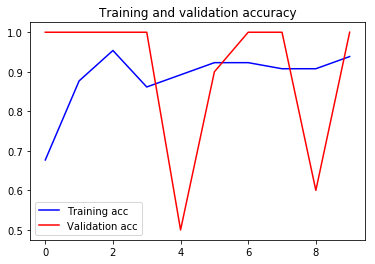

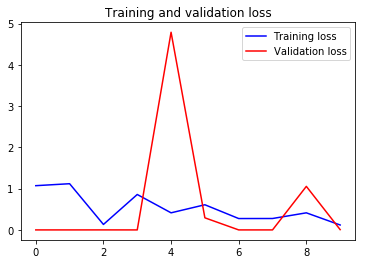

In [40]:
plt.plot(epochs, acc, 'b', color='blue', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 테스트하기

마지막으로 AI 모델이 실제로 X-ray 이미지를 잘 분류하는지 확인해보겠습니다.

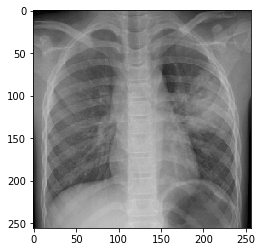

Predicted: Abd X-ray , Score: 0.5364042


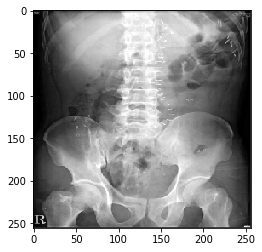

Predicted:  Abd X-ray , Score: 0.99959654


In [41]:
img1_path = 'D:\\yonsei_tutoring\\classification\\Open_I_abd_vs_CXRs\\TEST\\chest1.png'
img2_path = 'D:\\yonsei_tutoring\\classification\\Open_I_abd_vs_CXRs\\TEST\\abd2.png'

img1 = image.load_img(img1_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img2 = image.load_img(img2_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

plt.imshow(img1)
plt.show()

img1 = image.img_to_array(img1)
img1 /= 255.
img1 = img1[np.newaxis, :, :, :]
score1 = model.predict(img1)
print('Predicted:', 'Chest X-ray' if score1 < 0.5 else 'Abd X-ray', ', Score:', score1[0,0])

plt.imshow(img2)
plt.show()

img2 = image.img_to_array(img2)
img2 /= 255.
img2 = img2[np.newaxis, :, :, :]
score2 = model.predict(img2)
print('Predicted: ', 'Chest X-ray' if score2 < 0.5 else 'Abd X-ray', ', Score:', score2[0,0])